In [9]:
!pip install langchain
!pip install -q -U google-generativeai
!pip install gensim

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import csv
from statistics import mean
from langchain.llms import OpenAI
import os
import google.generativeai as genai
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import gensim.downloader as downloader
import gensim
import nltk
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
import datetime
import chardet
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [11]:
os.environ['API_KEY'] = 'Enter your API key here'

In [12]:
df = pd.read_csv("full_project_data.csv", quoting=csv.QUOTE_NONE)

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.shape

(1007, 65)

In [17]:
df.head()

,profiles_id,profiles_about,current_company_industry,current_company_link,current_company_name,current_company_title,current_company_company_id,education_degree,education_end_year,education_field,education_meta_info,education_start_year,education_title,education_url,educations_details,experience_company,experience_company_id,experience_description,experience_duration_short,experience_location,experience_start_date,experience_subtitle,experience_subtitle_URL,experience_title,experience_url,profiles_followers,profiles_following,post_attribution,post_created_at,post_link,post_title,recommendations,recommendations_count,profile_url,profiles_name,unique_subtitle,total_duration_days,all_durations,all_positions_descriptions,all_positions_titles,all_pos_start_date,all_pos_end_date,total_duration_years,total_duration_months,company_about,company_id,company_size,company_country_code,employees_title,employees_subtitle,employees_link,company_followers,formatted_locations,founded,headquarters,industries,company_name,organization_type,similar_links,similar_location,similar_subtitle,similar_title,sphere,company_url,post_content
0,jenbest6,Proven marketing leader with success in develo...,All American Entertainment,https://www.linkedin.com/company/aaespeakers?t...,All American Entertainment,VP of Marketing~ AAE Speakers Bureau | Board M...,aaespeakers,Bachelor of Science~Digital Marketing Executiv...,NaN,Marketing~Digital Marketing,Activities and Societies: Alpha Sigma Alpha~ s...,2022,University of Delaware~The George Washington U...,https://www.linkedin.com/school/university-of-...,University of Delaware,All American Entertainment~AMA Triangle~Thales...,aaespeakers~ama-triangle~thalesdis,NC TECH is a great organization fostering grow...,11 months~2 years 1 month~1 year 6 months~1 ye...,North Carolina~ United States~Florida~ United ...,Oct 2022~Jul 2021~Oct 2018~Nov 2016~Jan 2003,North Carolina Technology Association (NC TECH...,https://www.linkedin.com/company/north-carolin...,Board of Advisors~Advisory Board~ Digital Mark...,https://www.linkedin.com/company/aaespeakers?t...,2000.0,2000.0,By Jennifer Best,2021-08-16T00:00:00.000Z,https://www.linkedin.com/pulse/events-pivot-ag...,Are Events About to Pivot Again?,Trisha Paine “I had the privilege of working a...,16.0,https://www.linkedin.com/in/jenbest6,Jennifer Best,AMA Triangle,NaN,NaN,Oversees community programs including collegia...,(Volunteer) Board Member | VP~ Community Relat...,Jul 2023~Jun 2022~Feb 2021,Oct 2023~Jun 2023~Jun 2022,NaN,NaN,AMA Triangle's goal is to equip the NC Triangl...,2801539.0,201-500 employees,US,Brian Gossett~Jennifer Best~Karl Sakas~Hank Ho...,Results Oriented B2B Marketing Strategist | CE...,https://www.linkedin.com/in/bgossett?trk=org-e...,2064.0,Raleigh~ Durham + Chapel Hill~ North Carolina ...,1981.0,Raleigh~ Durham + Chapel Hill~ North Carolina,Advertising Services,AMA Triangle,Nonprofit,https://www.linkedin.com/company/kelaca?trk=si...,Raleigh~ North Carolina~Noblesville~ Indiana~R...,Human Resources Services~Non-profit Organizati...,Kelaca~Alpha Kappa Psi~North State Bank~Americ...,Advertising Services,https://www.linkedin.com/company/ama-triangle,Uncertainty and change have become central the...
3,seanmlee,Sean is a classically trained marketing execut...,Cincy Brands,https://www.linkedin.com/company/cincybrands?t...,Cincy Brands,President & Co-Founder @ Cincy Brands | Ex-P&G...,cincybrands,Master of Business Administration (M.B.A.)~B.B.A,2013~2009,NaN,2011 - 2013~2005 - 2009,2011~2005,Xavier University - Williams College of Busine...,https://www.linkedin.com/school/xavier-univers...,Xavier University - Williams College of Business,Amify~Procter & Gamble,amify~procter-and-gamble,I co-founded Cincy Brands to acquire and accel...,1 year 11 months~1 year 7 months~3 years~9 mon...,Cincinnati~ Ohio~ United States~Cincinnati~ OH...,Nov 2021~Mar 2018~Jan 2013~Sep 2009~Apr 2008~J...,"""Cincy Brands~Pure Romance~America Party Gear~...",https://www.linkedin.com/c

# Pre Process

In [18]:
# Replace '~' back to ','
df.replace("~", ",", regex=True, inplace=True)

In [19]:
date_format = "%b %Y"
# Function to convert a list of dates separated by commas to datetime objects
def convert_dates(date_str):
    if pd.isna(date_str):
        return date_str
    else:
        dates = date_str.split(',')
        converted_dates = []
        for date in dates:
            try:
                converted_date = pd.to_datetime(date.strip(), format=date_format)
                converted_dates.append(converted_date)
            except ValueError:
                # If the date cannot be converted to the expected format, append pd.NA
                converted_dates.append(pd.NA)
        return converted_dates

# Convert string representations of dates to datetime objects
df['all_pos_start_date'] = df['all_pos_start_date'].apply(convert_dates)
df['all_pos_end_date'] = df['all_pos_end_date'].apply(convert_dates)

In [20]:
# Extract years and months from the dates
def get_year_or_month(date, time):
  if time == 'month':
    return date.month if not pd.isna(date) else pd.NA
  if time == 'year':
    return date.year if not pd.isna(date) else pd.NA

df['all_pos_starting_year'] = df['all_pos_start_date'].apply(lambda x: [get_year_or_month(y, 'year') for y in x] if isinstance(x, list) else pd.NA)
df['all_pos_ending_year'] = df['all_pos_end_date'].apply(lambda x: [get_year_or_month(y, 'year') for y in x] if isinstance(x, list) else pd.NA)

df['all_pos_starting_month'] = df['all_pos_start_date'].apply(lambda x: [get_year_or_month(y, 'month') for y in x] if isinstance(x, list) else pd.NA)
df['all_pos_ending_month'] = df['all_pos_end_date'].apply(lambda x: [get_year_or_month(y, 'month') for y in x] if isinstance(x, list) else pd.NA)


In [21]:
# Fix total duration columns
def calculate_total_duration(row):
    start_dates = row['all_pos_start_date']
    end_dates = row['all_pos_end_date']
    if isinstance(start_dates, list) and isinstance(end_dates, list) and len(start_dates) == len(end_dates):
        # Check if any elements in the arrays are NaN
        if any(pd.isna(date) for date in start_dates) or any(pd.isna(date) for date in end_dates):
            return pd.NA
        durations = []
        for start_date, end_date in zip(start_dates, end_dates):
            if not pd.isna(start_date) and not pd.isna(end_date):
                duration = (end_date - start_date).days + 1
                durations.append(duration)
            else:
                # Handle missing values appropriately
                durations.append(pd.NA)
        return sum(durations)
    else:
        return pd.NA

In [22]:
# # Calculate total duration for each profile
# df['total_duration_days'] = df.apply(calculate_total_duration, axis=1)
# df['total_duration_months'] = df['total_duration_days'].apply(lambda x: x/30 if not pd.isna(x) else x)
# df['total_duration_years'] = df['total_duration_days'].apply(lambda x: x/365 if not pd.isna(x) else x)

In [23]:
# Modify text to list
df['education_end_year_list'] = df['education_end_year'].apply(lambda x: [int(y) for y in x.split(",")] if not pd.isna(x) else x)
df['education_start_year_list'] = df['education_start_year'].apply(lambda x: [int(y) for y in x.split(",")] if not pd.isna(x) else x)

In [24]:
# Calculate the statistics in numerical array cols
def convert_to_datetime(x):
  array_flag = False
  if ',' in str(x):
    x = x.split(',')
    array_flag = True
  if array_flag:
    result = []
    for timestamp in x:
      result.append(pd.to_datetime(x))
    result = [timestamp for datetime_index in result for timestamp in datetime_index]
    return result[0]
  elif not pd.isna(x):
    return [pd.to_datetime(x)]
  else:
    return pd.NA

In [25]:
df['post_timestamps'] = df['post_created_at'].apply(lambda x: convert_to_datetime(x))

## Extract label - did the person left the company in the following year?

In [26]:
# Filter current companies - we cannot know if the person left this company or not
df = df[df['company_name'] != df['current_company_name']]

In [27]:
# Calculate the years of starting and ending working in the company
df['company_start_year'] = df['all_pos_start_date'].apply(lambda x: min([y for y in x if not pd.isna(y)]).year if isinstance(x, list) and len([y for y in x if not pd.isna(y)]) > 0 else pd.NA)
df['company_end_year'] = df['all_pos_start_date'].apply(lambda x: max([y for y in x if not pd.isna(y)]).year if isinstance(x, list) and len([y for y in x if not pd.isna(y)]) > 0 else pd.NA)

<ipython-input-27-bd146ffde370>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['company_start_year'] = df['all_pos_start_date'].apply(lambda x: min([y for y in x if not pd.isna(y)]).year if isinstance(x, list) and len([y for y in x if not pd.isna(y)]) > 0 else pd.NA)


In [168]:
# Create row for each year in the range end date - start date, and add the label indicates
# if the person left the company in the following year
new_rows = []
for _, row in df.iterrows():
    start_year = row['company_start_year']
    end_year = row['company_end_year']
    if pd.isnull(start_year) or pd.isnull(end_year):
        continue
    for year in range(start_year, end_year + 1):
        new_row = row.copy()
        new_row['year'] = year
        new_row['years_in_company'] = year - start_year
        if year == end_year:
            new_row['label'] = 1
        else:
            new_row['label'] = 0
        new_rows.append(new_row)

In [169]:
new_df = pd.DataFrame(new_rows)
new_df.reset_index(drop=True, inplace=True)


In [31]:
new_df['label'].mean()

0.10730845661293884

In [32]:
new_df = new_df[new_df['label'].notna()]

In [33]:
new_df.shape

(4529, 77)

In [34]:
# Delete unrelevant columns or columns that can corrupt the model
cols_to_delete = ['current_company_industry', 'current_company_link', 'current_company_name', 'current_company_title',
                  'current_company_company_id', 'education_url', 'experience_company', 'experience_company_id',
                  'experience_duration_short', 'experience_location', 'experience_start_date',
                  'experience_subtitle_URL', 'experience_url', 'post_link', 'profile_url',
                  'all_durations', 'all_positions_descriptions', 'all_positions_titles',
                  'all_pos_ending_year', 'all_pos_start_date', 'all_pos_end_date', 'all_pos_starting_month',
                  'all_pos_ending_month', 'company_start_year', 'company_end_year']
new_df.drop(columns=cols_to_delete, inplace=True)

# Feature Engineering

In [35]:
array_cols = ['education_degree',
 'education_end_year',
 'education_field',
 'education_start_year',
 'education_title',
 'post_attribution',
 'post_title',
 'employees_title',
 'employees_subtitle',
 'formatted_locations',
 'similar_location',
 'similar_subtitle',
 'similar_title']

In [36]:
# Add the number of unique items for each array col
for col in array_cols:
  new_df[f'{col}_counts'] = new_df[col].apply(lambda x: len(set(x.split(','))) if not pd.isna(x) else pd.NA)

In [37]:
# Add the number of posts written before the current year
new_df['post_timestamps'] = new_df['post_timestamps'].apply(lambda x: [ts.replace(tzinfo=None) for ts in x] if isinstance(x, list) else x)

new_df['posts_count'] = new_df.apply(lambda x: len([y for y in x['post_timestamps'] if y <= pd.to_datetime(f'01-01-{x["year"]}').replace(tzinfo=None)])
                                             if isinstance(x['post_timestamps'], list) else 0, axis=1)


In [38]:
def find_position_count(row):
  if not isinstance(row['all_pos_starting_year'], list):
    return pd.NA
  return len([y for y in row['all_pos_starting_year'] if not pd.isna(y) and y <= row["year"]])

In [39]:
# Add the number of position the person had inside the company, until the current year
new_df['positions_count'] = new_df.apply(lambda x: find_position_count(x), axis=1)

In [40]:
#Calculate the statistics in numerical array cols
def calculate_statistics(x, function):
  array_flag = False
  if isinstance(x, list):
    for i, val in enumerate(x):
      x[i] = float(val)
    array_flag = True
  if array_flag:
    if function == 'mean':
      return mean(x)
    elif function == 'max':
      return max(x)
    elif function == 'min':
      return min(x)
    else:
      return pd.NA
  else:
    return x


In [41]:
numerical_array_cols =['education_end_year_list', 'education_start_year_list']
for col in numerical_array_cols:
  df[f'average_{col}'] = df[col].apply(lambda x: calculate_statistics(x, 'mean'))
  df[f'max_{col}'] = df[col].apply(lambda x: calculate_statistics(x, 'max'))
  df[f'min_{col}'] = df[col].apply(lambda x: calculate_statistics(x, 'min'))


In [42]:
# Extract time features
new_df['posts_years'] = new_df['post_timestamps'].apply(lambda x: [y.year for y in x] if isinstance(x, list) else pd.NA)
new_df['posts_months'] = new_df['post_timestamps'].apply(lambda x: [y.month for y in x] if isinstance(x, list) else pd.NA)
new_df['posts_week_days'] = new_df['post_timestamps'].apply(lambda x: [y.day_name() for y in x] if isinstance(x, list) else pd.NA)

In [43]:
new_df = new_df[new_df['company_size'] != '1 employee']

In [44]:
new_df['company_size'] = new_df['company_size'].apply(lambda x: x.replace('10,001+', "10000-10000000") if not pd.isna(x) else x)
new_df['array_company_size'] = new_df['company_size'].apply(lambda x: x.replace(' employees', '').replace(',', '').split('-') if not pd.isna(x) else x)

<ipython-input-44-79ed3ea634eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['company_size'] = new_df['company_size'].apply(lambda x: x.replace('10,001+', "10000-10000000") if not pd.isna(x) else x)
<ipython-input-44-79ed3ea634eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['array_company_size'] = new_df['company_size'].apply(lambda x: x.replace(' employees', '').replace(',', '').split('-') if not pd.isna(x) else x)


In [45]:
# Create company size related columns
new_df['max_company_size'] = new_df['array_company_size'].apply(lambda x: int(x[1]) if isinstance(x, list) else pd.NA)
new_df['min_company_size'] = new_df['array_company_size'].apply(lambda x: int(x[0]) if isinstance(x, list) else pd.NA)
new_df['mean_company_size'] = new_df['array_company_size'].apply(lambda x: (int(x[1]) + int(x[0])) / 2 if isinstance(x, list) else pd.NA)

<ipython-input-45-018a0160d69d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['max_company_size'] = new_df['array_company_size'].apply(lambda x: int(x[1]) if isinstance(x, list) else pd.NA)
<ipython-input-45-018a0160d69d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['min_company_size'] = new_df['array_company_size'].apply(lambda x: int(x[0]) if isinstance(x, list) else pd.NA)
<ipython-input-45-018a0160d69d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [46]:
# Calculate the duration of education for each profile
# Drop education that was taken after the row's year from the calculation
new_df['education_duration'] = new_df.apply(lambda row:
                                     sum(row['education_end_year_list'][i] - row['education_start_year_list'][i] + 1
                                         for i in range(len(row['education_start_year_list']))
                                         if row['education_start_year_list'][i] <= row['year'])
                                     if (isinstance(row['education_end_year_list'], list) and
                                         isinstance(row['education_start_year_list'], list) and
                                         len(row['education_end_year_list']) == len(row['education_start_year_list']))
                                     else pd.NA, axis=1)


# Display the DataFrame with education duration
new_df[['profiles_id', 'education_start_year_list', 'education_end_year_list', 'education_duration', 'year']].dropna()

,profiles_id,education_start_year_list,education_end_year_list,education_duration,year
3,seanmlee,"[2011.0, 2005.0]","[2013.0, 2009.0]",8.0,2019
4,seanmlee,"[2011.0, 2005.0]","[2013.0, 2009.0]",8.0,2020
31,liyin58,"[2004.0, 2004.0, 2000.0]","[2008.0, 2008.0, 2004.0]",15.0,2011
32,liyin58,"[2004.0, 2004.0, 2000.0]","[2008.0, 2008.0, 2004.0]",15.0,2012
33,liyin58,"[2004.0, 2004.0, 2000.0]","[2008.0, 2008.0, 2004.0]",15.0,2013
...,...,...,...,...,...
13289,richard-wilcoxon-mba-shrm-scp-7b7a265,"[2006.0, 2000.0, 1995.0, 1991.0]","[2008.0, 2003.0, 1997.0, 1995.0]",15.0,2016
13290,richard-wilcoxon-mba-shrm-scp-7b7a265,"[2006.0, 2000.0, 1995.0, 1991.0]","[2008.0, 2003.0, 1997.0, 1995.0]",15.0,2017
13291,richard-wilcoxon-mba-shrm-scp-7b7a265,"[2006.0, 2000.0, 1995.0, 1991.0]","[2008.0, 2003.0, 1997.0, 1995.0]",15.0,2018
13292,richard-wilcoxon-mba-shrm-scp-7b7a265,"[2006.0, 2000.0, 1995.0, 1991.0]","[2008.0, 2003.0, 1997.0, 1995.0]",15.0,2019


In [47]:
# Add company's age
new_df['company_age'] = new_df.apply(lambda x: x['year'] - int(x['founded']) if not pd.isna(x['founded']) and x['founded'] != 0 and x['year'] - int(x['founded']) > 0 else pd.NA, axis=1)

In [48]:
def find_state(x):
  if pd.isna(x):
    return x
  if isinstance(x, float):
    print(x)
  if len(x.split(",")) < 2:
    return pd.NA
  else:
    return x.split(",")[1]

In [49]:
# Find the company's headquarter state
new_df['headquarters_state'] = new_df['headquarters'].apply(lambda x: find_state(x))

In [50]:
categorial_fields = ['education_degree', 'education_title', 'educations_details', 'company_size', 'headquarters', 'organization_type', 'headquarters_state','profiles_id', 'company_name']
numerical_fields = ['profiles_followers',	'years_in_company', 'profiles_following', 'recommendations_count', 'company_followers', 'education_duration',	'company_age'] + [col for col in new_df.columns if 'count' in col or 'mean' in col or 'min' in col or 'max' in col]

In [51]:
textual_cols = ['profiles_about', 'education_field', 'experience_description',
                'experience_title', 'post_title', 'recommendations', 'company_about',
                'employees_subtitle', 'industries', 'similar_subtitle', 'post_content']


## Create Features Based on Textual Fields



Let's use Gemini to extract textual features

In [52]:
# Initialize gemini model
genai.configure(api_key=os.environ["API_KEY"])
model = genai.GenerativeModel('gemini-pro')

In [53]:
def send_prompt(prompt, x):
  if pd.isna(x):
    return pd.NA
  try:
    response = model.generate_content(prompt).text
  except Exception as e:
    print(e)
    response = pd.NA
  return response

In [54]:
prompt = "Here are the posts by some user in Linkdin app. What is the sentiment that best describes this post? use one word out of the following: Positive, Negative, Neutral"
post_contents_senteiment = {}
for post in new_df['post_content'].unique():
  post_contents_senteiment[post] = send_prompt(prompt, post)

400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.
400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


In [55]:
# Sentiment analysis for the user's posts
new_df['posts_sentiment'] = new_df['post_content'].apply(lambda x: post_contents_senteiment[x] if x in post_contents_senteiment.keys() else pd.NA)

In [56]:
prompt ="Here are the posts by some user in Linkdin app. They are ordered by their creation time, from the newest to the oldest. Do you recognize a trend in the posts? use one word out of the following: Positive, Negative, Neutral"
post_contents_trend = {}
for post in new_df['post_content'].unique():
  post_contents_trend[post] = send_prompt(prompt, post)

400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.
400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


In [57]:
# Evaluate the user's posts' trend - is it a positive trend or negative one?
new_df['posts_trend'] = new_df['post_content'].apply(lambda x:  post_contents_trend[x] if x in post_contents_trend.keys() else pd.NA)

In [58]:
# # Find the profile's main occupation

# def generate_occupation(row):
#     prompt = "Following is the information of a LinkedIn user under the 'About' section, along with its titles (newest to oldest). Write in one word what is the user's main occupation in his work."
#     about_section = row['profiles_about']
#     experience_title = row['experience_title']

#     if pd.isna(about_section) and pd.isna(experience_title):
#         return pd.NA
#     if not pd.isna(about_section):
#         prompt += about_section
#     if not pd.isna(experience_title):
#         prompt += experience_title
#     try:
#       response = model.generate_content(prompt).text
#     except Exception as e:
#       print(e)
#       response = pd.NA
#     return response

# new_df['user_occupation'] = new_df.apply(generate_occupation, axis=1)

In [59]:
# # Find the main field of the company

# def generate_company_field(row):
#     prompt = "Following is the information of a company in LinkedIn user under the 'About' section, along with the industries that are relvant for the company. Write in one word what is the company's main field."
#     about_section = row['company_about']
#     experience_description = row['industries']

#     if pd.isna(about_section) and pd.isna(experience_description):
#         return pd.NA
#     if not pd.isna(about_section):
#         prompt += about_section
#     if not pd.isna(experience_description):
#         prompt += experience_description
#     try:
#       response = model.generate_content(prompt).text
#     except Exception as e:
#       print(e)
#       response = pd.NA
#     return response

# new_df['company_field'] = new_df.apply(generate_company_field, axis=1)

In [60]:
prompt = "Here are the titles of all the employees in a company, as appears in its Linkedin account. Find me the title that best describes the employees title and work. Use one word."
employees_title = {}
for title in new_df['employees_subtitle'].unique():
  employees_title[title] = send_prompt(prompt, post)

400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.
400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.


In [61]:
#Find a title that best describes the employees work

new_df['company_employees_title'] = new_df['employees_subtitle'].apply(lambda x: employees_title[x])

In [62]:
#gemini_features = ['posts_sentiment', 'posts_trend', 'user_occupation', 'company_field', 'company_employees_title']
gemini_features = ['posts_sentiment', 'posts_trend', 'company_employees_title']

In [63]:
# Delete values that contain more than one word - indicated that there was a problem with gemini's response
def delete_unvalid(value):
  if pd.isna(value):
    return pd.NA
  if len(value.split(' ')) > 1:
    return pd.NA
  return value

In [64]:
for feature in gemini_features:
  new_df[feature] = new_df[feature].apply(lambda x: delete_unvalid(x))

In [65]:
categorial_fields += gemini_features

# Data Analysis
Let's review the different features we've got

## Categorial Features

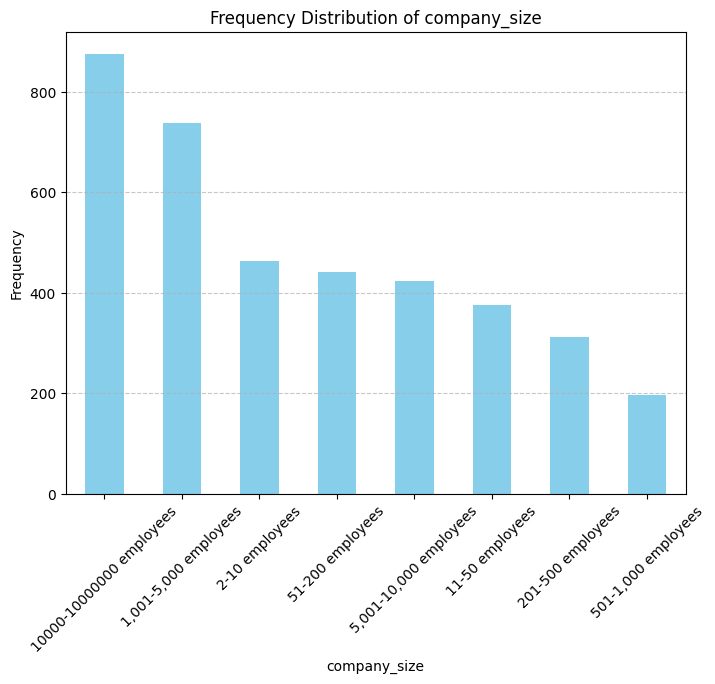

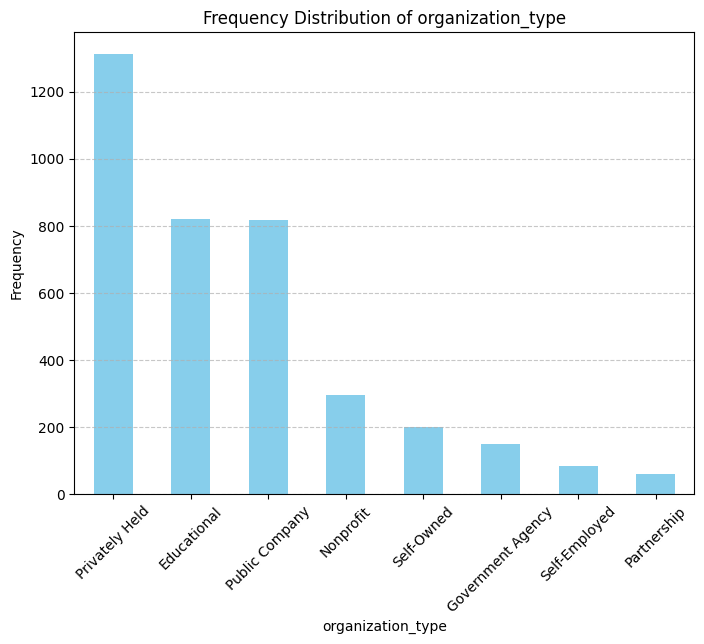

In [66]:
# Include only features with small number of different categories
for feature in categorial_fields:
  if new_df[feature].nunique() < 20 and new_df[feature].nunique() > 1:
    try:
        category_counts = new_df[feature].value_counts()
        plt.figure(figsize=(8, 6))
        category_counts.plot(kind='bar', color='skyblue')
        plt.title(f'Frequency Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    except Exception:
        continue

# Numerical Features

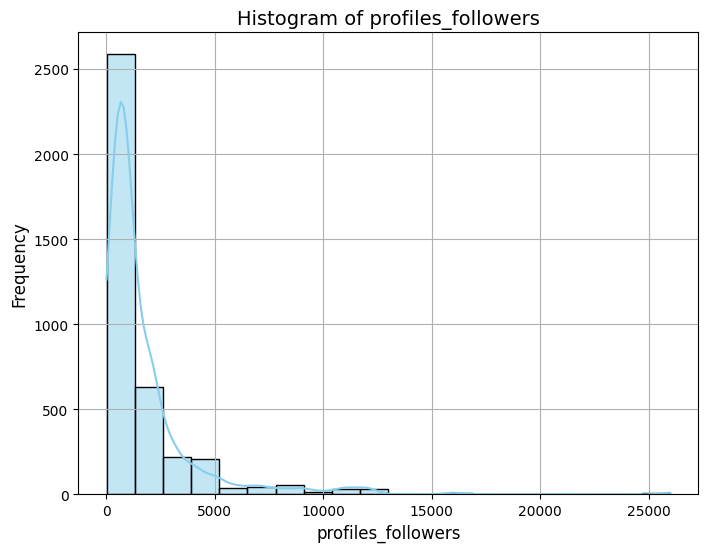

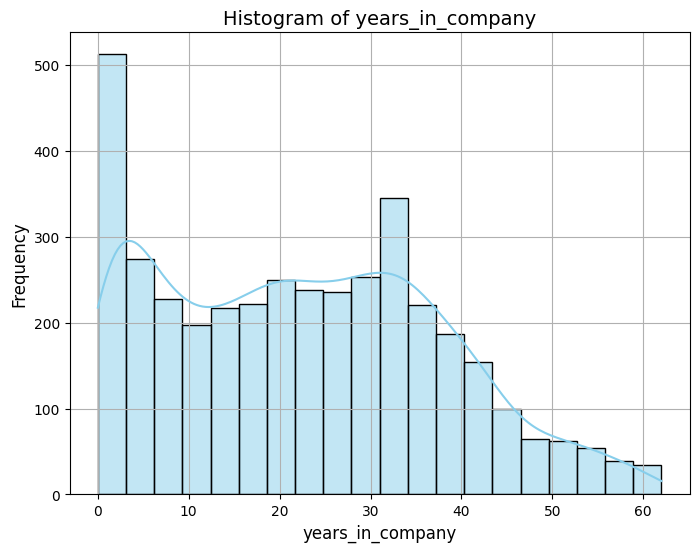

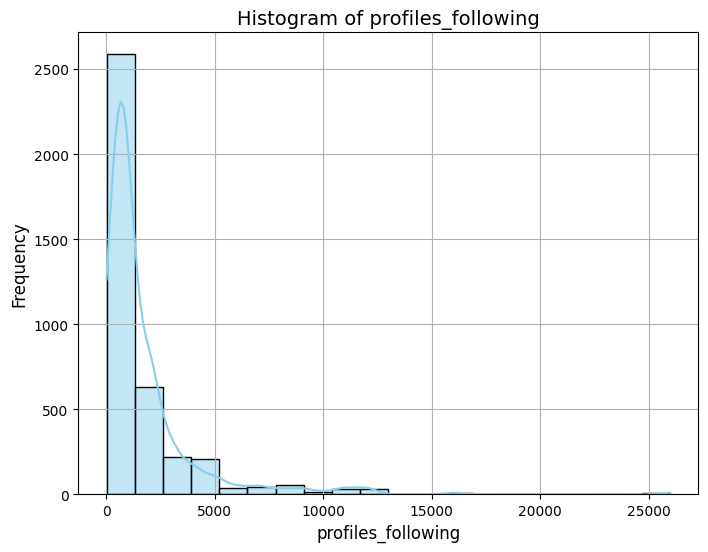

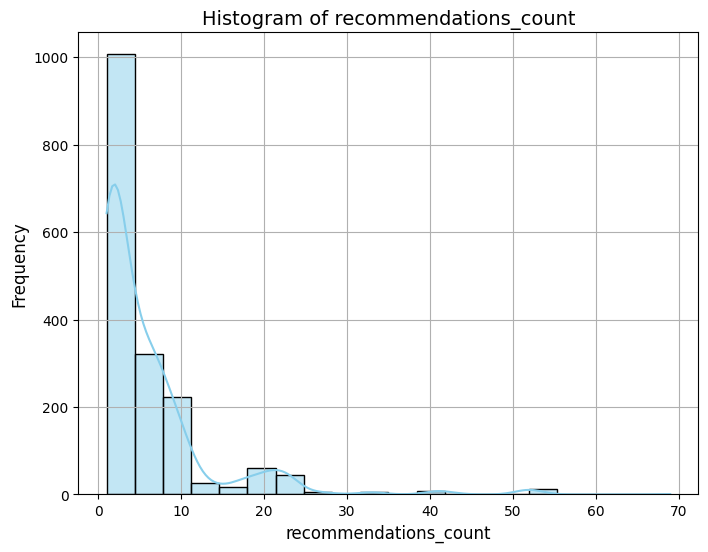

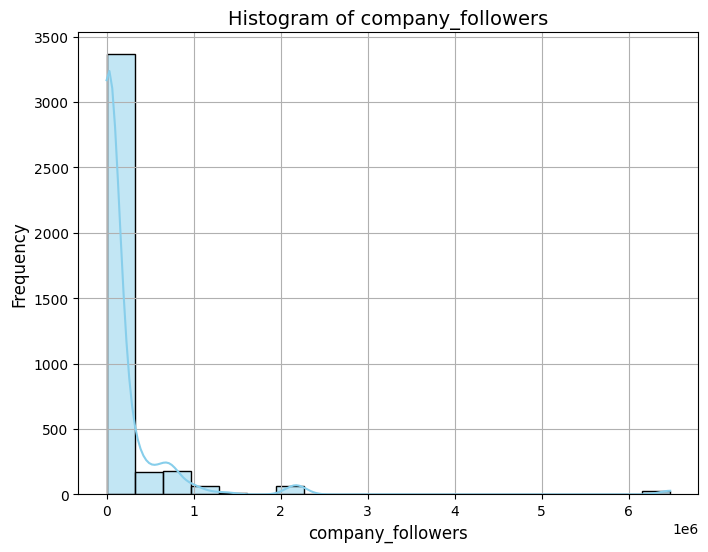

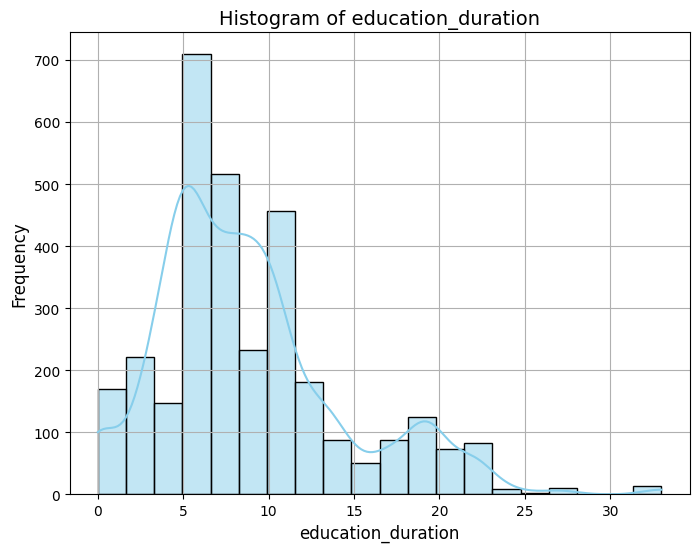

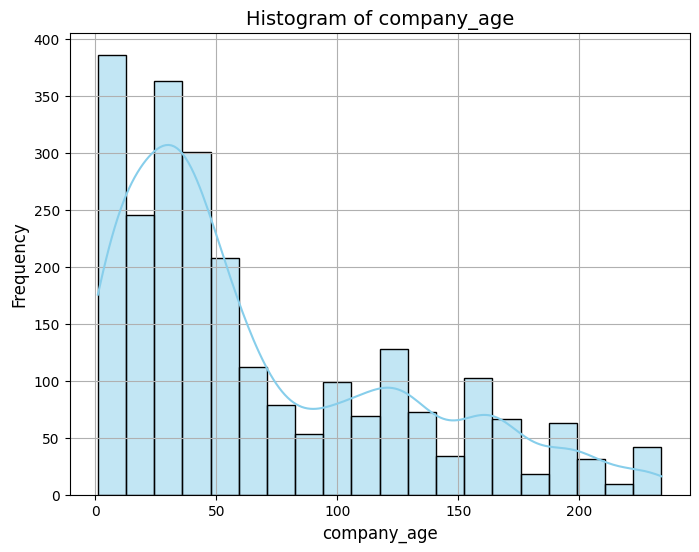

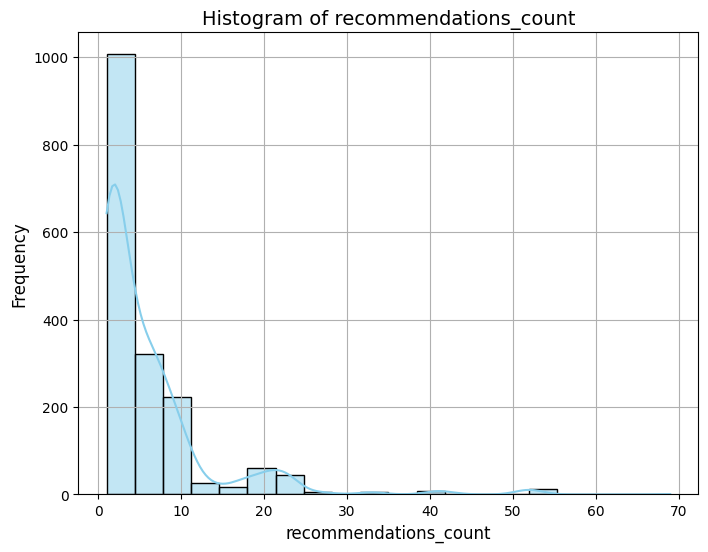

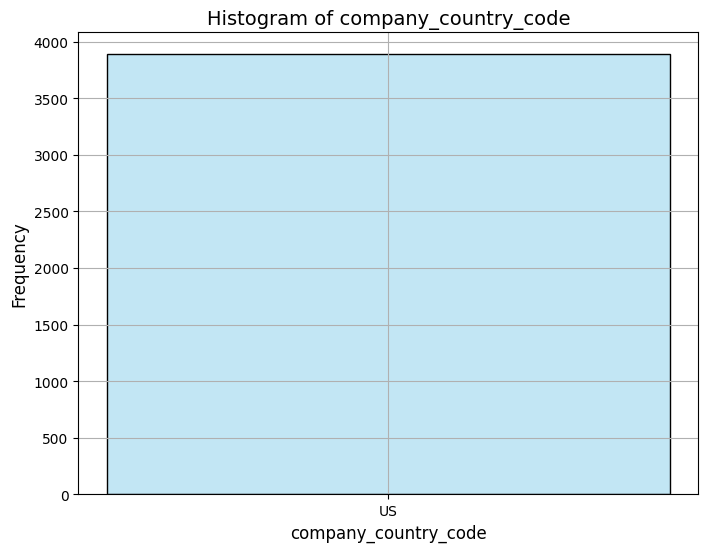

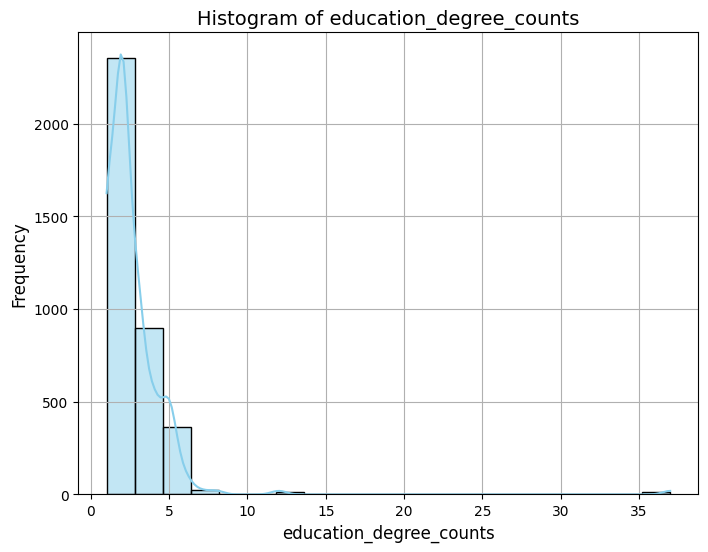

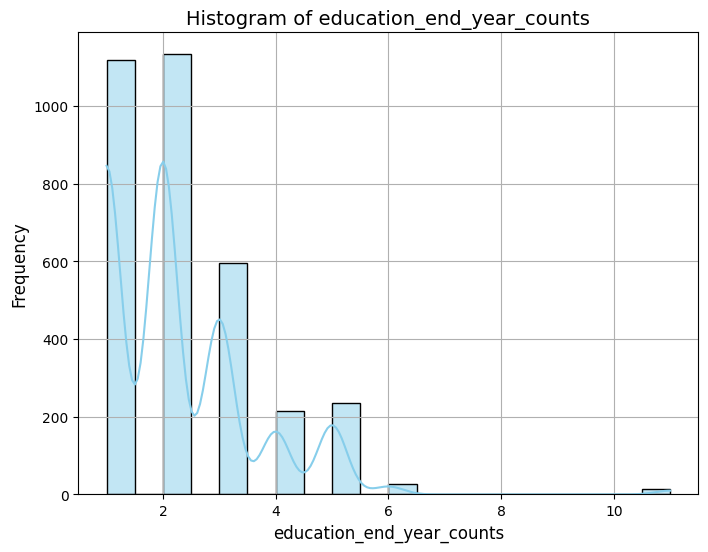

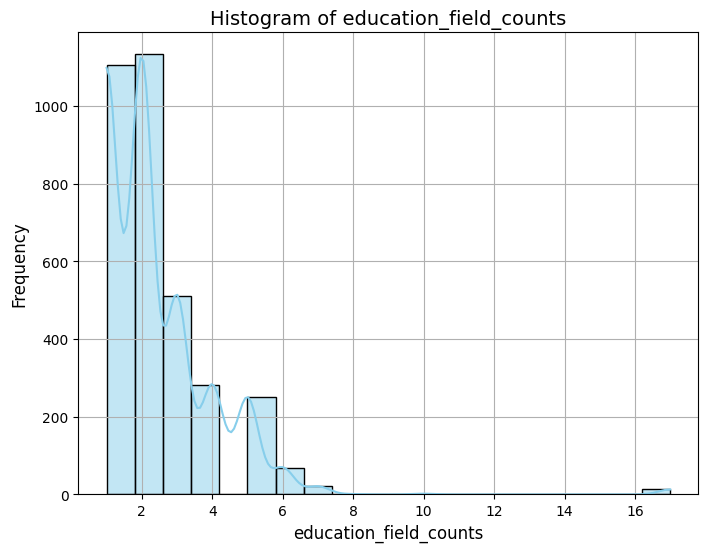

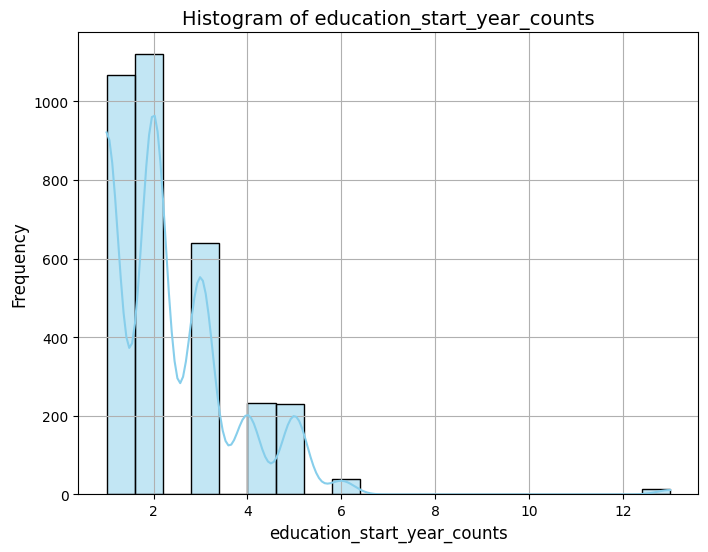

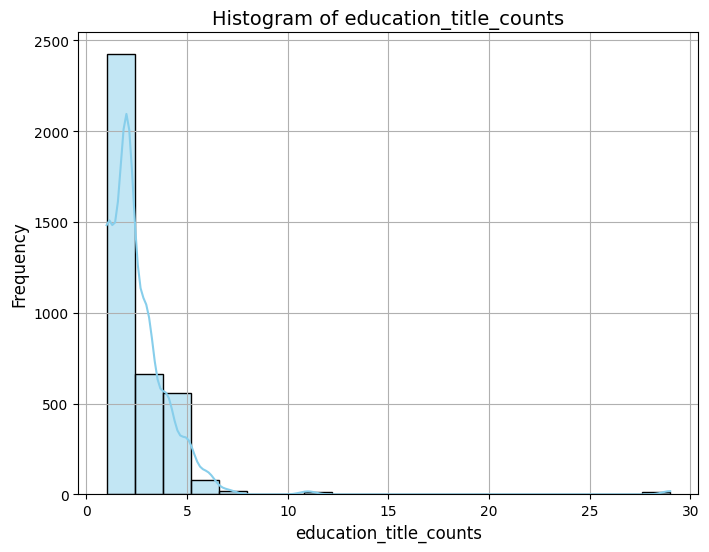

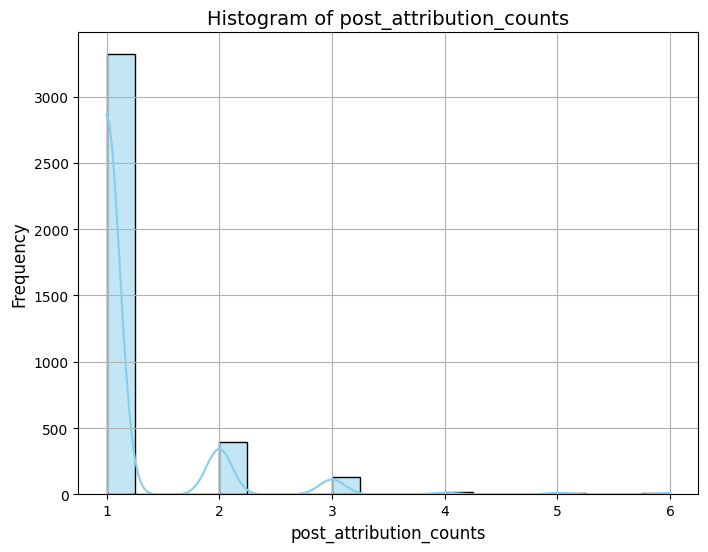

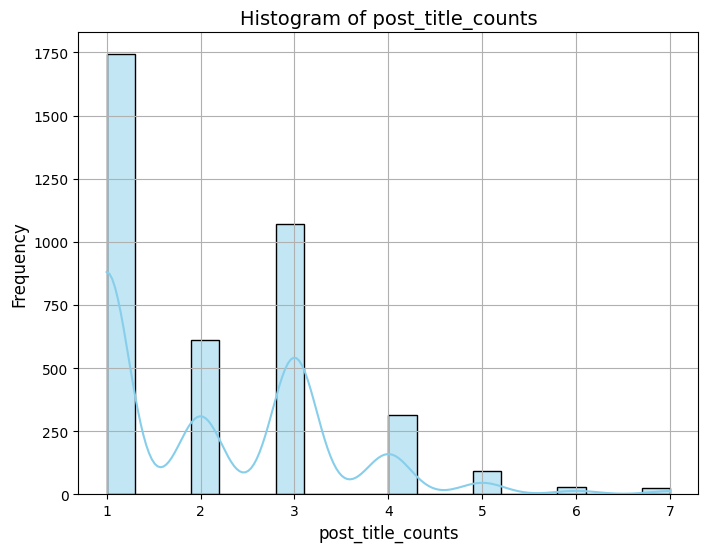

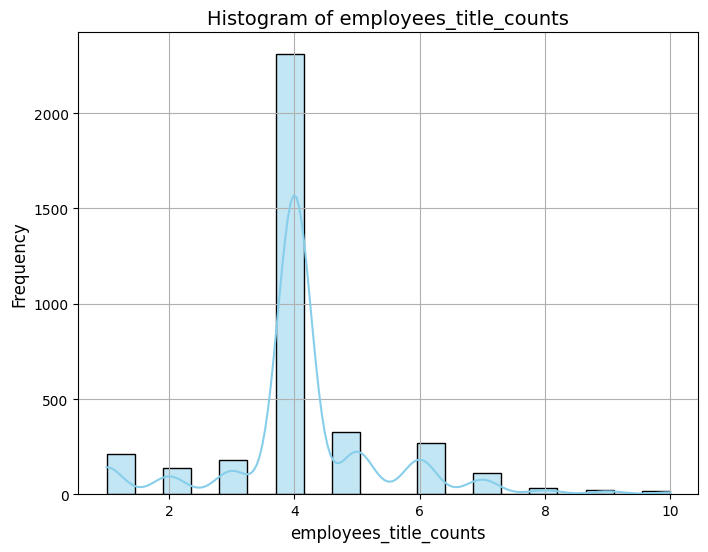

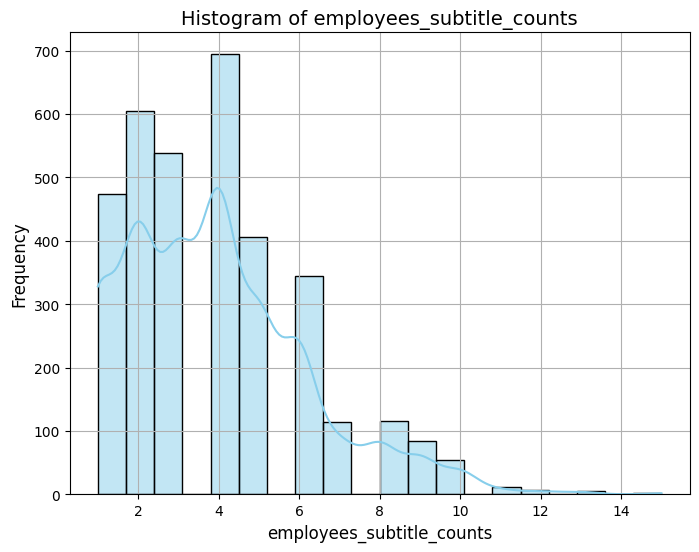

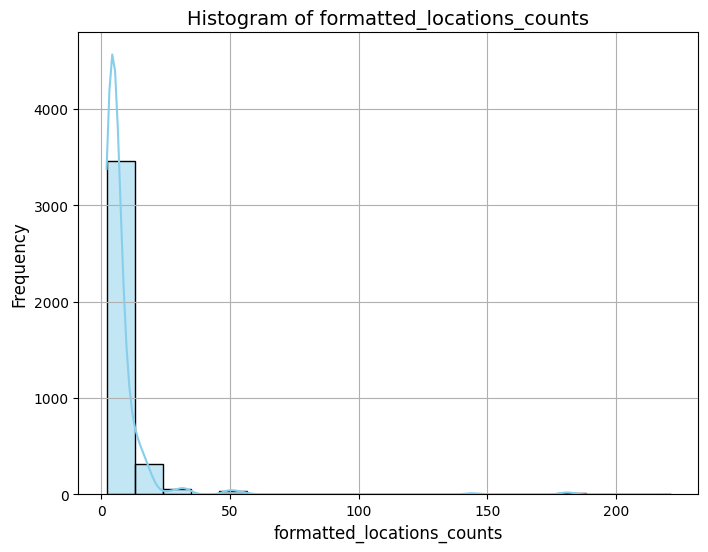

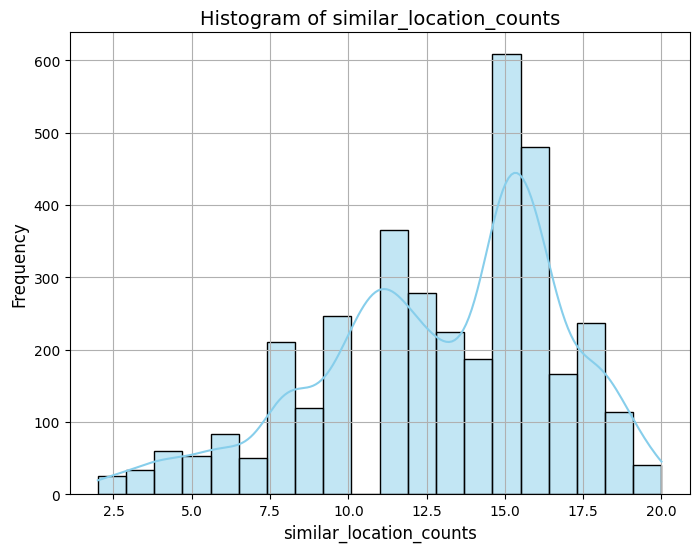

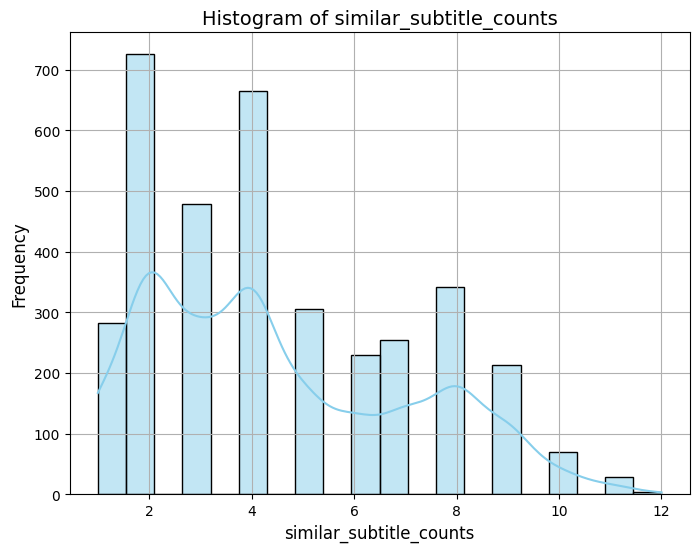

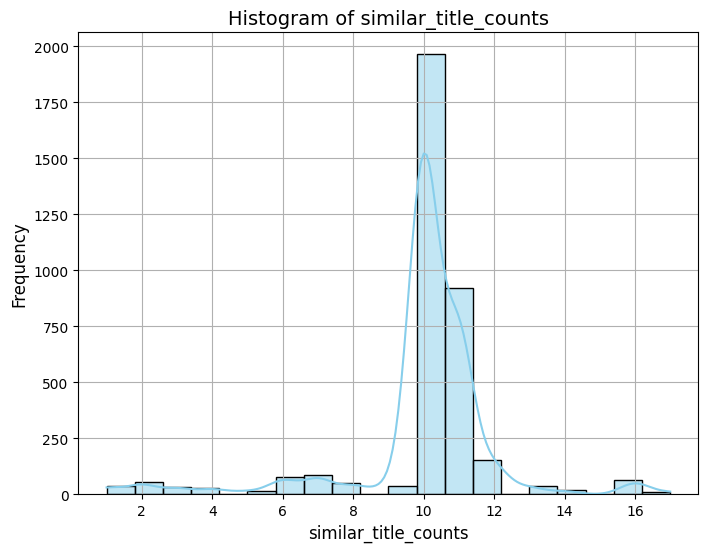

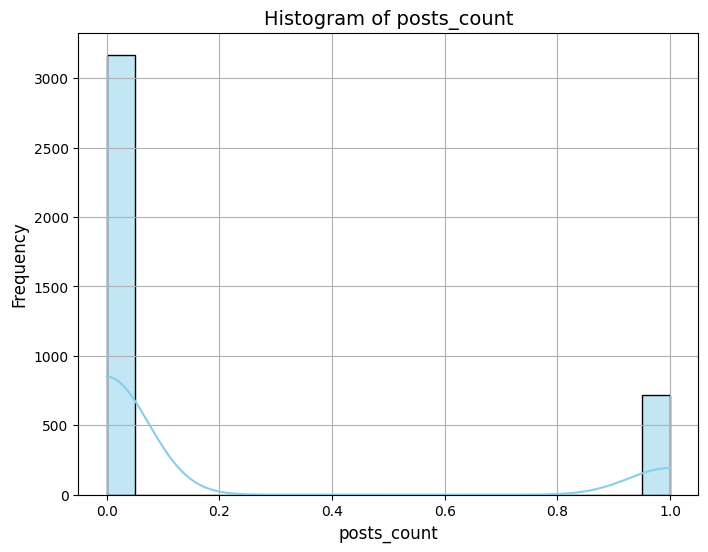

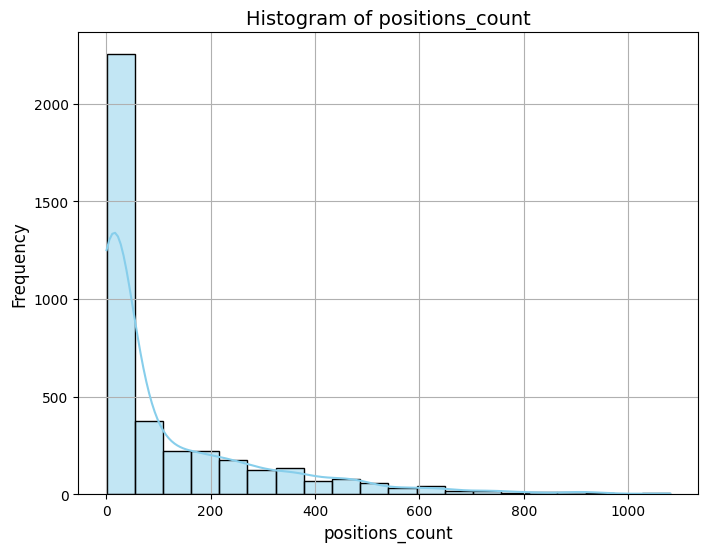

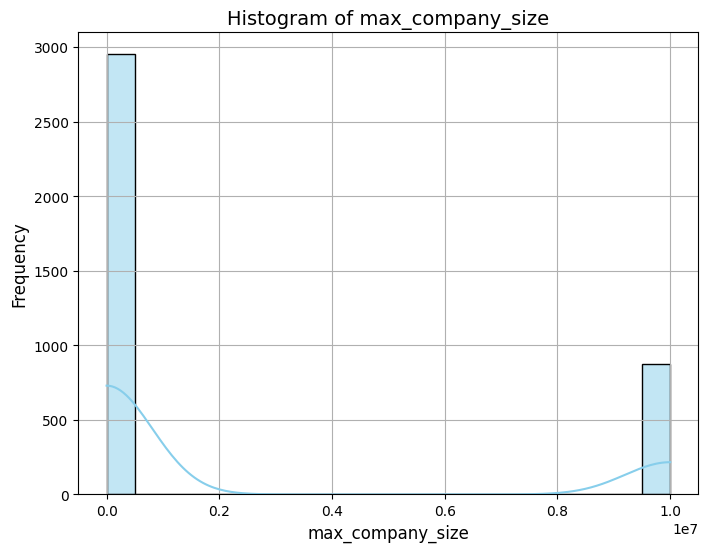

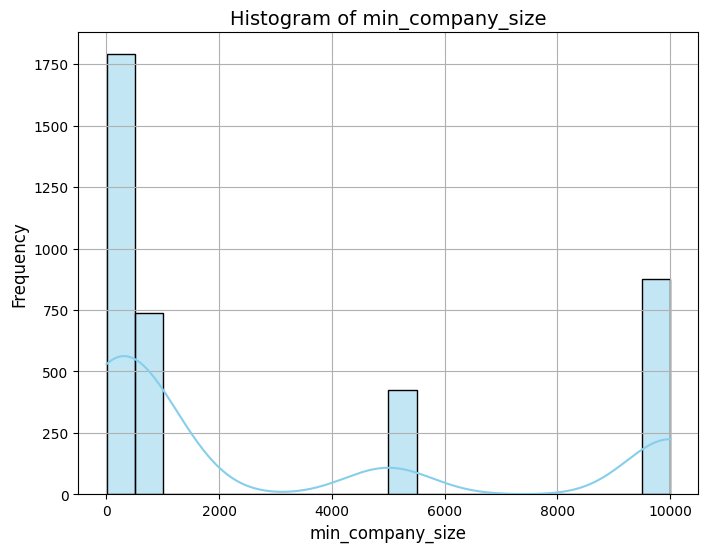

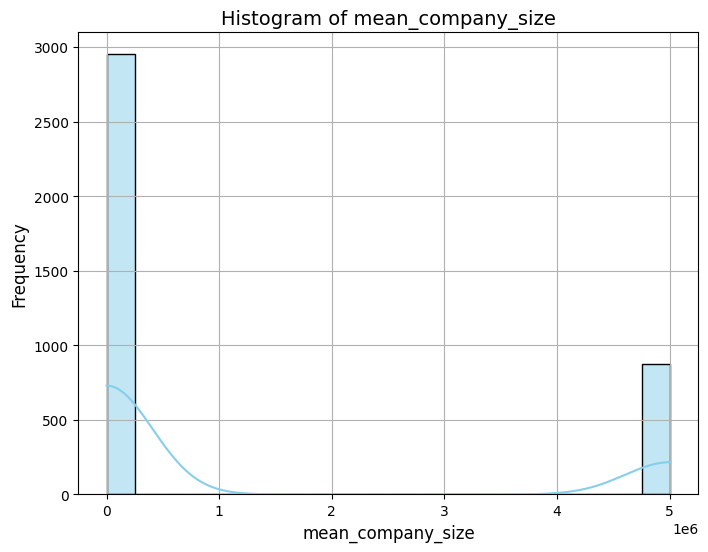

In [67]:
# Plot histograms for each numerical feature
for column in numerical_fields:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=new_df, x=column, bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.show()

# Features Embedding

## Textual Features Embedding

In [68]:
# Use glove the create embedding for the textual features
GLOVE_PATH = 'glove-twitter-25'
glove_model = downloader.load(GLOVE_PATH)

[==================================================] 100.0% 104.8/104.8MB downloaded


In [69]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [70]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [71]:
# Clean the text from stopwords
def text_preprocess(text):
    from nltk.corpus import stopwords
    stopword = stopwords.words('english')
    if not isinstance(text, str):
        return pd.NA
    words_text = nltk.word_tokenize(text)
    words_text = [word.lower() for word in words_text if word.isalpha() and word.lower() != 'null' and word.lower() not in stopword]
    return str(words_text)

In [72]:
def text_embedding(text_column, embedding_model, max_length=200):
    """
    Convert textual data to word embeddings using a pre-trained GloVe embedding model.
    """
    embedded_text = []
    for text in text_column:
        if pd.isna(text):
            embedded_text.append(np.zeros((max_length, embedding_model.vector_size)))  # Pad with zero vectors
        else:
            text = text_preprocess(text)
            word_embeddings = []
            for word in text.split():
                if word in embedding_model:
                    word_embeddings.append(embedding_model[word])
                else:
                    word_embeddings.append(np.random.rand(embedding_model.vector_size))
            embedded_text.append(word_embeddings[:max_length])  # Limit to max_length
    # Flatten the embedded_text list
    flattened_embeddings = [np.hstack(emb) for emb in embedded_text]
    return flattened_embeddings

In [73]:
# for col in ['experience_description', 'post_content']:
#   new_df[col + '_embedding'] = text_embedding(new_df[col], glove_model)

## Categorical and Array Features Embedding

In [74]:
# Encode categorical features as one hot vectors
def one_hot_encoding(x, categories):
    encoded_vector = [0] * (len(categories) + 1)
    if pd.isna(x):
      encoded_vector[len(categories)] = 1
    elif x in categories:
      encoded_vector[categories.index(x)] = 1
    return np.array(encoded_vector)

In [75]:
for col in categorial_fields:
  encoded_df = pd.get_dummies(new_df[col])
  for new_col in encoded_df.columns:
    encoded_df.rename({new_col: f'{col}_{new_col}_encoded'}, axis=1, inplace=True)
  new_df = pd.merge(new_df, encoded_df, left_index=True, right_index=True)

In [76]:
encoded_cols = [col for col in new_df.columns if 'encoded' in col]

In [77]:
features = numerical_fields + [col for col in df.columns if "embedding" in col or col.endswith("vector")] + encoded_cols

In [80]:
new_df.shape

(3886, 2133)

In [81]:
X = new_df[features + ['year']]
y = new_df['label']

In [82]:
y.mean()

0.1116829644879053

In [83]:
X.shape

(3886, 2081)

## Fill Nulls

In [84]:
for col in numerical_fields:
  try:
    X[col] = X[col].fillna(X[col].mean())
  except Exception as E:
    continue

<ipython-input-84-b7152ccac988>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mean())


# Feature Selection

In [85]:
array_cols = [col for col in X.columns if 'embedded' in col]

In [86]:
# Moved this code the comment since using embedding data didn't yield improvment in results, and took long time to run
# cordinates_cols = []
# for col in array_cols:
#     if X[col].isna().mean() == 1:
#       array_cols.remove(col)
#       continue
#     max_elements = max(len(arr) for arr in X[col] if isinstance(arr, np.ndarray))
#     for i in range(max_elements):
#         X[f'{col}_{i+1}'] = X[col].apply(lambda x: x[i] if isinstance(x, np.ndarray) and len(x) > i else None)
#         cordinates_cols.append(f'{col}_{i+1}')
#     X.drop(columns=[col], inplace=True)

In [87]:
numerical_features = [col for col in X.columns if 'embedding' not in col and 'vector' not in col and 'post' not in col and col not in encoded_cols]

In [88]:
X[X['year'] >= 2021].shape[0] / X.shape[0]

0.19068450849202265

In [89]:
# Divide dataset to train and test by times (the earlier years should be in the training set)
indexes = X[X['year'] < 2021].index.to_list()
X_train = X[X.index.isin(indexes)].drop(columns=['year'])
X_test = X[~X.index.isin(indexes)].drop(columns=['year'])
y_train = y[y.index.isin(indexes)]
y_test = y[~y.index.isin(indexes)]


In [90]:
numerical_features.remove('year')

In [91]:
numerical_features.remove('company_country_code')

In [92]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train[numerical_features])

# Perform feature selection on the scaled data
selector = SelectKBest(score_func=chi2, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
selected_features = X_train[numerical_features].columns[selector.get_support()]

In [174]:
selected_features

['company_followers',
 'positions_count',
 'mean_company_size',
 'years_in_company',
 'min_company_size',
 'max_company_size',
 'education_end_year_counts',
 'company_age',
 'education_start_year_counts',
 'employees_title_counts']

In [95]:
# Balance the labels by creating syntetic labels
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [96]:
# Fill null values
for col in X_train.columns:
  try:
    X_train[col] = X_train[col].fillna(X[col].mean())
  except Exception as E:
    continue
  try:
    X_test[col] = X_test[col].fillna(X[col].mean())
  except Exception as E:
    continue

# Model Selection

In [113]:
# Drop cols that are all nones
for col in X_train.columns:
  if col == 'recommendations_count':
    continue
  if X_train[col].isna().mean() == 1:
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)

In [123]:
# Define weights to the classes, in favor of 1 labels
class_weights = {
    0: 0.3,
    1: 0.7
}

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Random Forest': RandomForestClassifier(class_weight=class_weights),
    'Gradient Boosting': GradientBoostingClassifier()}

# Hyperparameter grid for GridSearchCV
param_grid = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200, 500, 1000, 5000]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200]}
}

# Initialize lists to store results
results = []
auc_results = []
correlation_results = []

In [124]:
# Initialize lists to store results
results = []
auc_results = []
correlation_results = []
recall_results = []
f1_results = []
accuracy_results = []
roc_auc_results = []
y_pred_probas = []

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    clf = GridSearchCV(model, param_grid[name], cv=5, error_score='raise')
    clf.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_proba)

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_results.append({'Model': name, 'ROC AUC': roc_auc, 'FPR': fpr, 'TPR': tpr})

    # Calculate correlation
    correlation = np.corrcoef(y_test, y_pred_proba)[0, 1]

    # Calculate recall
    recall = recall_score(y_test, y_pred)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    # Store results
    results.append({
        'Model': name,
        'Parameter': str(clf.best_params_),
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1,
        'Correlation': correlation,
        'AUC': auc
    })
    auc_results.append({'Model': name, 'AUC': auc})
    correlation_results.append({'Model': name, 'Correlation': correlation})
    recall_results.append({'Model': name, 'Recall': recall})
    f1_results.append({'Model': name, 'F1 Score': f1})
    accuracy_results.append({'Model': name, 'Accuracy': accuracy})

# Convert results and scores to DataFrames
recall_df = pd.DataFrame(recall_results)
f1_df = pd.DataFrame(f1_results)
accuracy_df = pd.DataFrame(accuracy_results)
auc_df = pd.DataFrame(auc_results)
display(pd.DataFrame(results))

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...


,Model,Parameter,Accuracy,Recall,F1 Score,Correlation,AUC
0,Logistic Regression,{'C': 0.01},0.577598,0.175000,0.238443,0.031786,0.519151
1,Random Forest,{'n_estimators': 1000},0.623482,0.017857,0.034602,0.089403,0.583793
2,Gradient Boosting,{'n_estimators': 200},0.628880,0.046429,0.086379,0.099708,0.535908


# Evaluate Results

<ipython-input-125-f34b9b61c518>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_df, x='Model', y='Accuracy', palette='coolwarm', ax=axes[0][0])
<ipython-input-125-f34b9b61c518>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=auc_df, x='Model', y='AUC', palette='coolwarm', ax=axes[0][1])
<ipython-input-125-f34b9b61c518>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recall_df, x='Model', y='Recall', palette='coolwarm', ax=axes[1][0])
<ipython-input-125-f34b9b61c518>:20: FutureWarning: 

Passing `palette` without 

Text(0, 0.5, 'F1 Score')

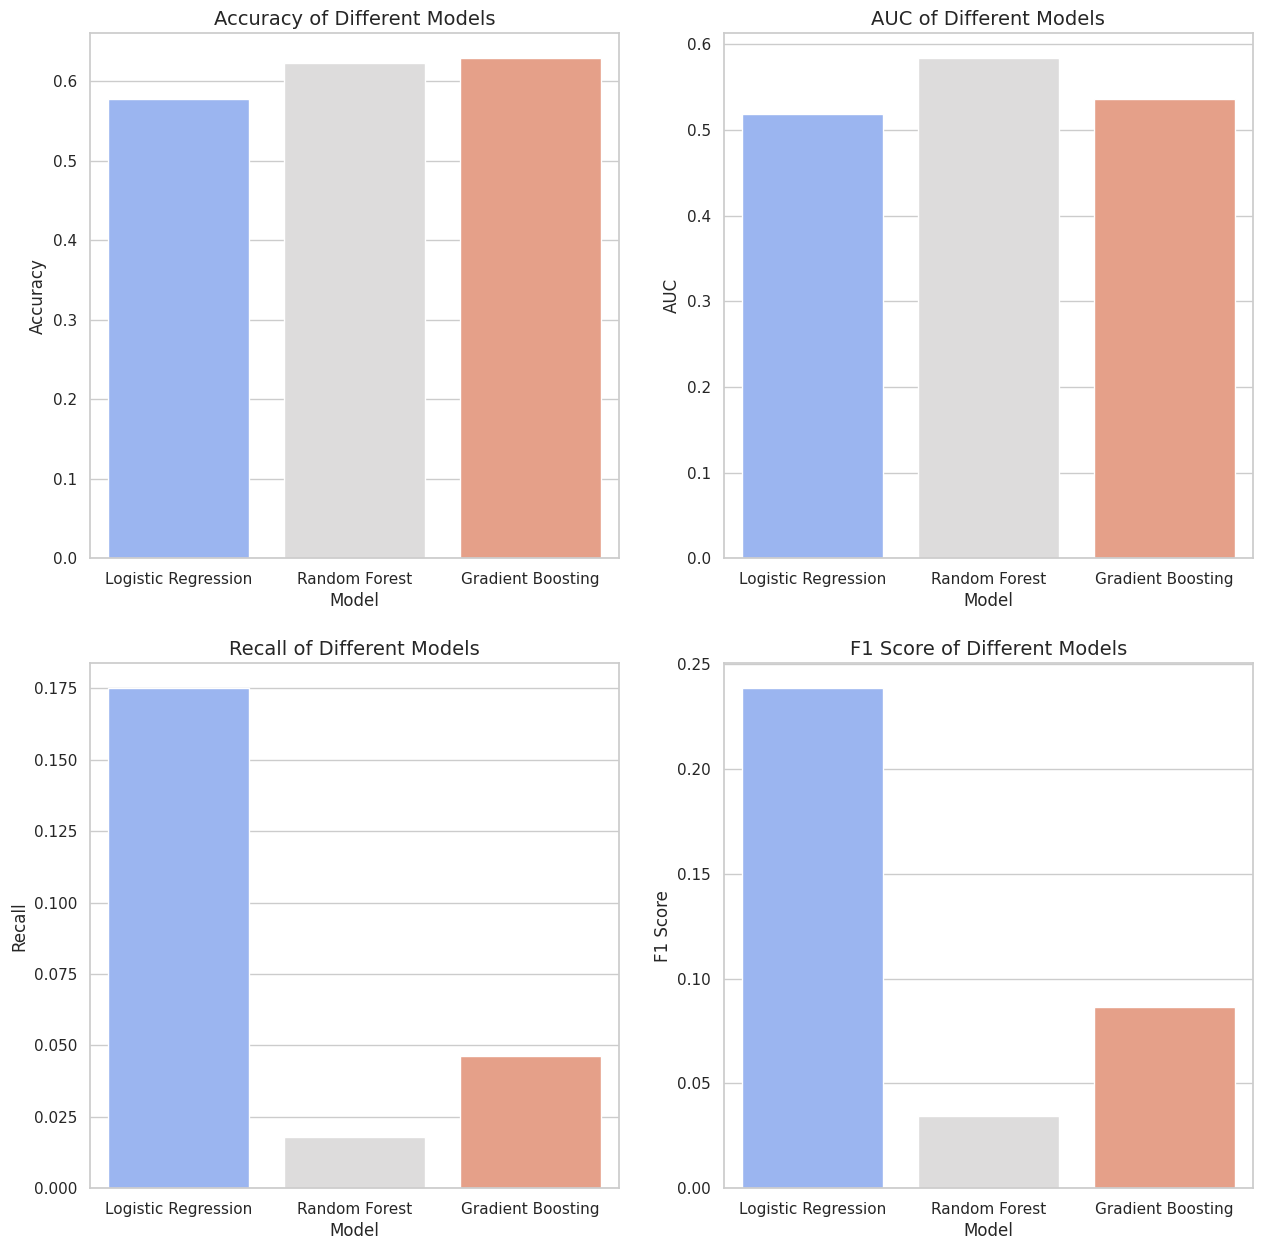

In [125]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.barplot(data=accuracy_df, x='Model', y='Accuracy', palette='coolwarm', ax=axes[0][0])
axes[0][0].set_title('Accuracy of Different Models', fontsize=14)
axes[0][0].set_xlabel('Model', fontsize=12)
axes[0][0].set_ylabel('Accuracy', fontsize=12)


sns.barplot(data=auc_df, x='Model', y='AUC', palette='coolwarm', ax=axes[0][1])
axes[0][1].set_title('AUC of Different Models', fontsize=14)
axes[0][1].set_xlabel('Model', fontsize=12)
axes[0][1].set_ylabel('AUC', fontsize=12)


sns.barplot(data=recall_df, x='Model', y='Recall', palette='coolwarm', ax=axes[1][0])
axes[1][0].set_title('Recall of Different Models', fontsize=14)
axes[1][0].set_xlabel('Model', fontsize=12)
axes[1][0].set_ylabel('Recall', fontsize=12)

sns.barplot(data=f1_df, x='Model', y='F1 Score', palette='coolwarm', ax=axes[1][1])
axes[1][1].set_title('F1 Score of Different Models', fontsize=14)
axes[1][1].set_xlabel('Model', fontsize=12)
axes[1][1].set_ylabel('F1 Score', fontsize=12)

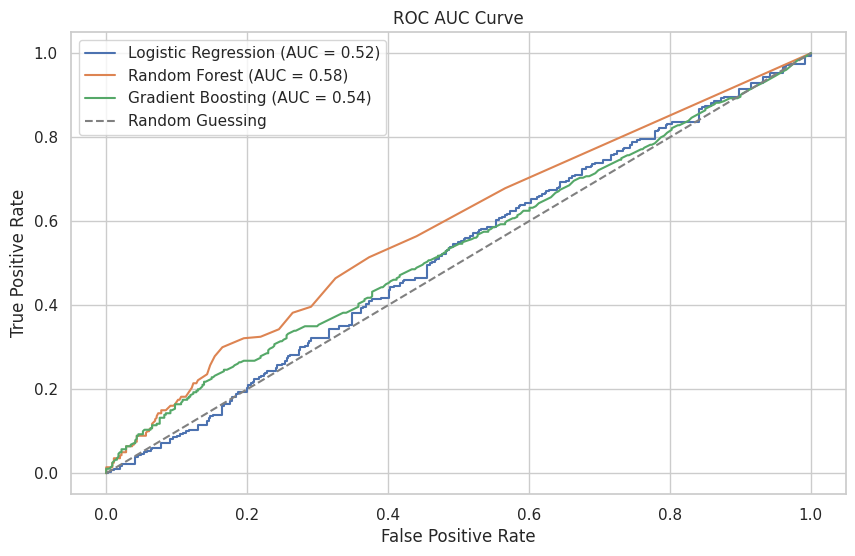

In [126]:
# Plot ROC CURVE
# Create DataFrame for ROC AUC results
roc_auc_df = pd.DataFrame(roc_auc_results)
plt.figure(figsize=(10, 6))
for idx, row in roc_auc_df.iterrows():
    fpr = row['FPR']
    tpr = row['TPR']
    plt.plot(fpr, tpr, label=f'{row["Model"]} (AUC = {row["ROC AUC"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.grid(True)
plt.show()

## Feature Importance

In [166]:
# By random forest
rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

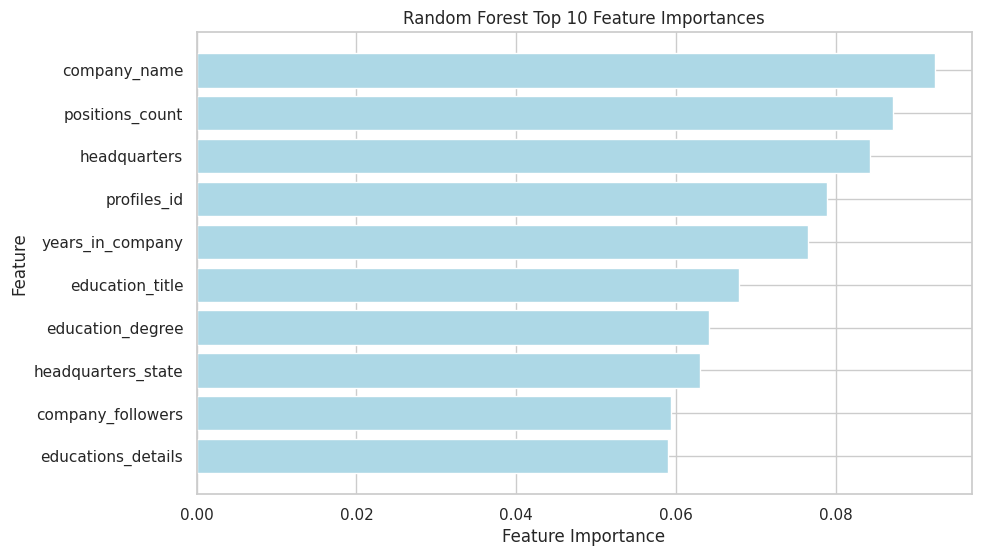

In [167]:
# Combine feature importances for one-hot encoded features into original feature importances
original_feature_importances = {}
for i, feature_name in enumerate(X_train.columns):
    if feature_name in encoded_cols:
        if feature_name.startswith("headquarters") and not feature_name.startswith("headquarters_state"):
          original_feature_name = feature_name.split('_')[0]
        else:
          original_feature_name = '_'.join(feature_name.split('_')[:2])
        importance = feature_importances[i]
        original_feature_importances.setdefault(original_feature_name, 0)
        original_feature_importances[original_feature_name] += importance
    else:
      original_feature_importances[feature_name] = feature_importances[i]

# Sort original feature importances in descending order
sorted_original_feature_importances = sorted(original_feature_importances.items(), key=lambda x: x[1], reverse=True)

# Extract top n feature names and importances
top_n = 10
top_original_feature_names = [item[0] for item in sorted_original_feature_importances][:top_n]
top_original_feature_importances = [item[1] for item in sorted_original_feature_importances][:top_n]

# Plot top feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_original_feature_importances)), top_original_feature_importances, align='center', color='lightblue')
plt.yticks(range(len(top_original_feature_names)), top_original_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Top {} Feature Importances'.format(top_n))
plt.gca().invert_yaxis()
plt.show()


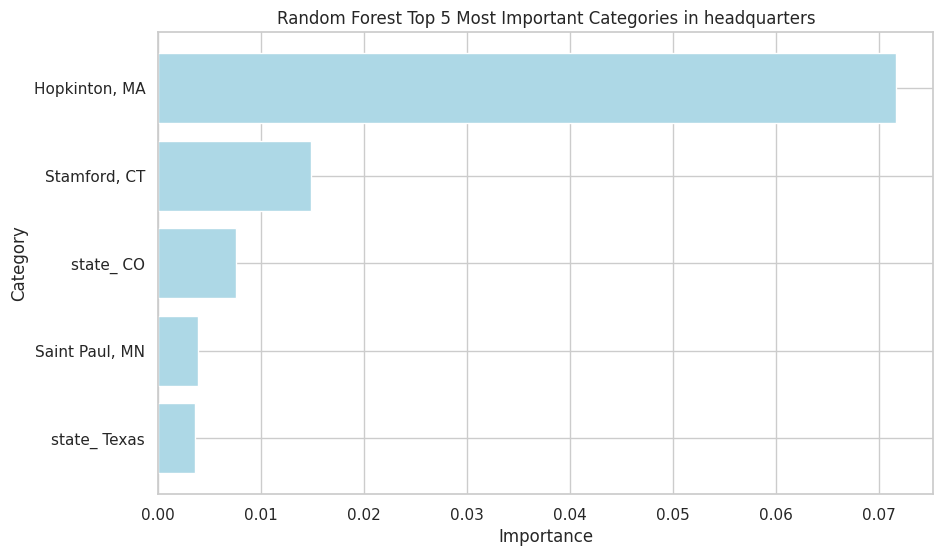

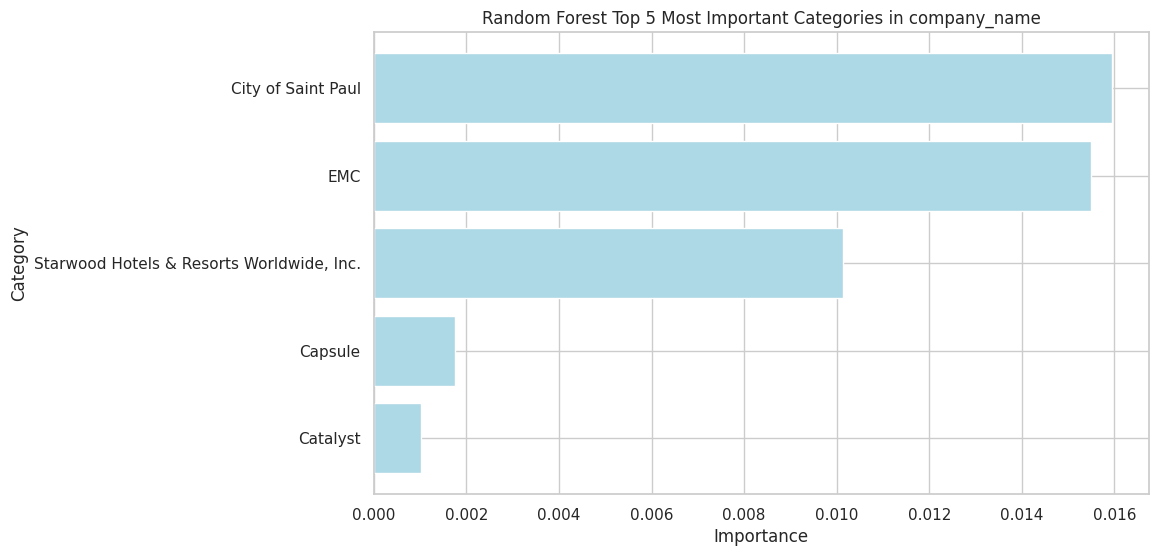

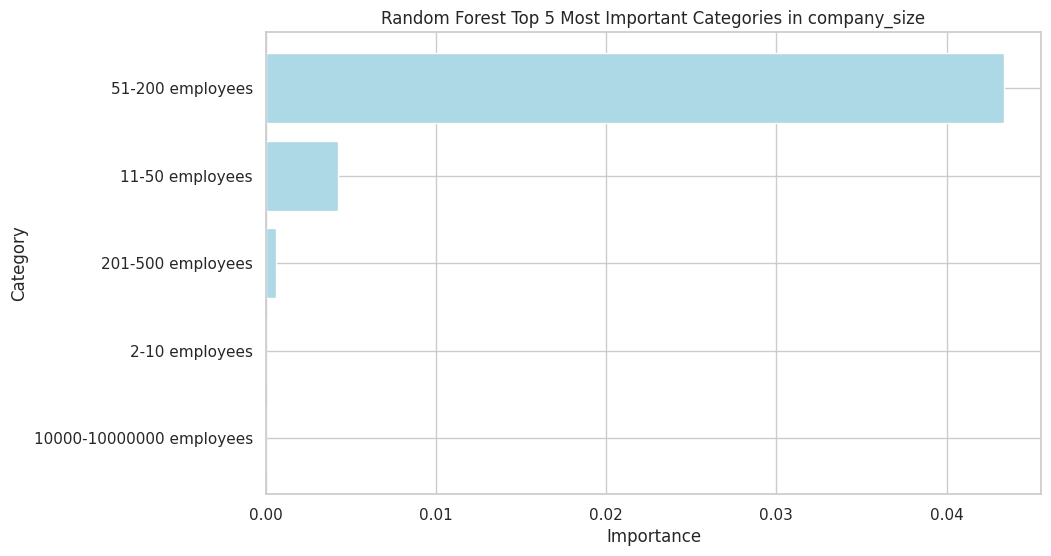

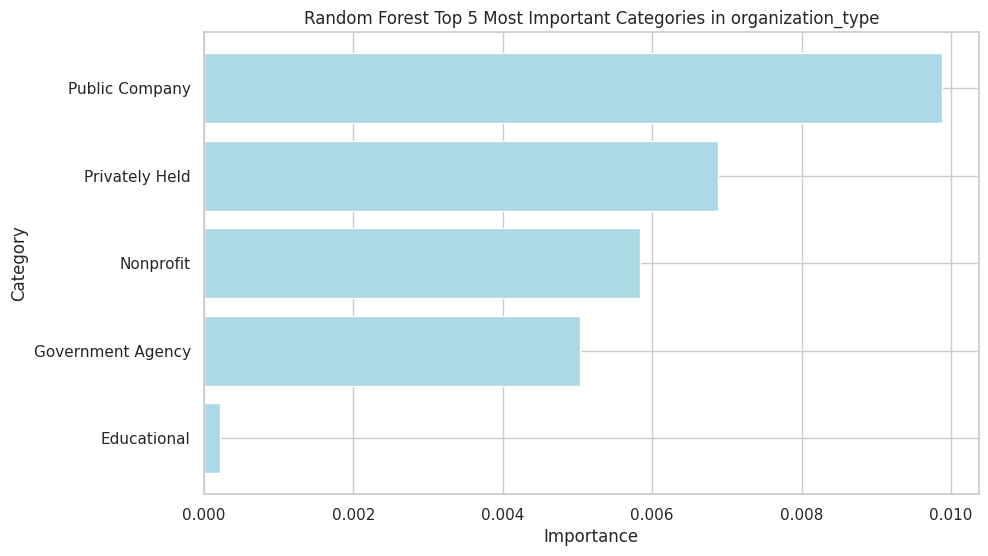

In [163]:
for feature_name in top_original_feature_names:
    importance_per_col = {}
    if feature_name in categorial_fields:
        columns = [col for col in X_train.columns if col.startswith(feature_name) and col.endswith("encoded")]
        for col in columns:
          index_of_column = X_train.columns.get_loc(col)
          importance_per_col[col.replace(feature_name +'_', "").replace("_encoded", "")] = feature_importances[index_of_column]
        sorted_categories_importances = sorted(importance_per_col.items(), key=lambda x: x[1], reverse=True)
        top_n = 5
        top_categories = [item[0] for item in sorted_categories_importances][:top_n]
        top_cateogries_importances = [item[1] for item in sorted_categories_importances][:top_n]

        # Plot top categories
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(top_categories)), top_cateogries_importances, align='center', color='lightblue')
        plt.yticks(range(len(top_categories)), top_categories)
        plt.xlabel('Importance')
        plt.ylabel('Category')
        plt.title(f'Random Forest Top {top_n} Most Important Categories in {feature_name}')
        plt.gca().invert_yaxis()
        plt.show()




In [164]:
# By Gradient Boosting
gradient_model = GradientBoostingClassifier(n_estimators=200)
gradient_model.fit(X_train, y_train)

# Get feature importances
feature_importances = gradient_model.feature_importances_

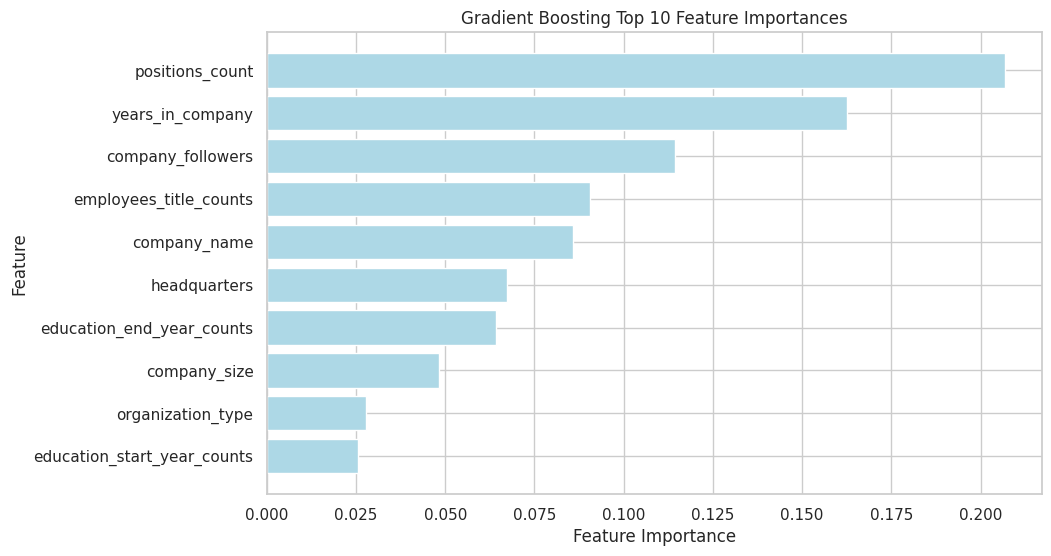

In [165]:
# Combine feature importances for one-hot encoded features into original feature importances
original_feature_importances = {}
for i, feature_name in enumerate(X_train.columns):
    if feature_name in encoded_cols:
        if feature_name.startswith("headquarters") and not feature_name.startswith("headquarters_state"):
          original_feature_name = feature_name.split('_')[0]
        else:
          original_feature_name = '_'.join(feature_name.split('_')[:2])
        importance = feature_importances[i]
        original_feature_importances.setdefault(original_feature_name, 0)
        original_feature_importances[original_feature_name] += importance
    else:
      original_feature_importances[feature_name] = feature_importances[i]

# Sort original feature importances in descending order
sorted_original_feature_importances = sorted(original_feature_importances.items(), key=lambda x: x[1], reverse=True)

# Extract top n feature names and importances
top_n = 10
top_original_feature_names = [item[0] for item in sorted_original_feature_importances][:top_n]
top_original_feature_importances = [item[1] for item in sorted_original_feature_importances][:top_n]

# Plot top feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_original_feature_importances)), top_original_feature_importances, align='center', color='lightblue')
plt.yticks(range(len(top_original_feature_names)), top_original_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Top {} Feature Importances'.format(top_n))
plt.gca().invert_yaxis()
plt.show()
